In [57]:

import pandas as pd
import numpy as np
import warnings



import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, log_loss, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(10,5)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split

import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)

Text(0.5, 1.0, 'Test Dataset: Missing Values')

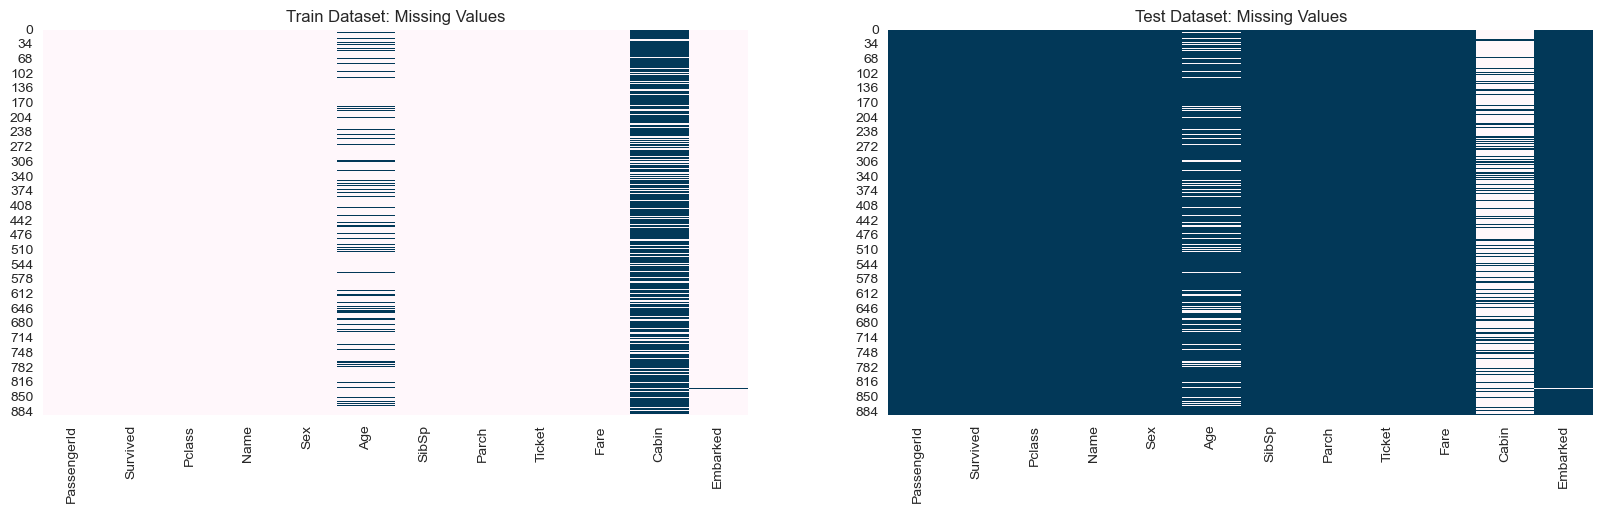

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu',ax=ax[0])
ax[0].set_title('Train Dataset: Missing Values')
sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu_r',ax=ax[1])
ax[1].set_title('Test Dataset: Missing Values')

In [4]:
# Show missing values for the entire dataset
def missing_tbl(df):
    tbl = pd.DataFrame()
    
    tbl['Column'] = df.columns
    tbl['Missing'] = [df[col].isnull().sum() for col in df.columns]
    tbl['Percentage'] = [round((df[col].isnull().sum() / df.shape[0])*100, 2) for col in df.columns]
    return tbl


missing_tbl(entire_df)

,Column,Missing,Percentage
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,263,20.09
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,1,0.08


Text(0.5, 1.0, 'Age Distribution')

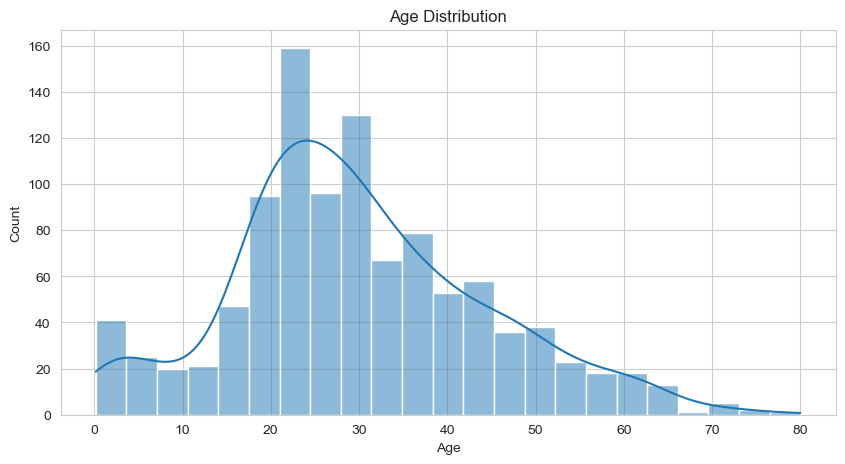

In [5]:
sns.histplot(data=entire_df['Age'], kde=True)
plt.title('Age Distribution')

In [6]:
# Create Title column by extracting title from Name column
def create_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.split(', ', expand=True)[1]
    df['Title'] = df['Title'].str.split('.', expand=True)[0]
    return df


entire_df = create_title(entire_df)

In [7]:
# Standardized Title column
def standardized_title(df):
    df = df.copy()
    
    # Unmarried woman
    unmarried_w = ['Mlle', 'Ms']
    for uw in unmarried_w:
        df['Title'].replace({uw : 'Miss'}, inplace=True)
    
    # Married woman
    married_w = ['Dona', 'Mme', 'Lady', 'the Countess']
    for mv in married_w:
        df['Title'].replace({mv : 'Mrs'}, inplace=True)
    
    # Man
    man = ['Don', 'Rev', 'Capt', 'Col', 'Major', 'Jonkheer', 'Sir']
    for m in man:
        df['Title'].replace({m : 'Mr'}, inplace=True)
        
    return df


# Apply function
entire_df = standardized_title(entire_df)

In [8]:
# Compute the correlation between Age and Categorical Features
from pandas import factorize

def cat_corr(feature):
    categories = ['Sex', 'Title', 'Embarked']
    print('Correlation between {} and Categorical Features:'.format(feature))
    for cat in categories:
        labels, categories = factorize(entire_df[cat])
        entire_df['labels'] = labels
        correlation = abs(entire_df[feature].corr(entire_df['labels']))
        print('{} : {:.4f}'.format(cat, correlation))
        entire_df.drop('labels', axis=1, inplace=True)
        
cat_corr('Age')

Correlation between Age and Categorical Features:
Sex : 0.0636
Title : 0.3821
Embarked : 0.0424


In [9]:
# Fill age with median 
median_age = entire_df.groupby('Title')['Age'].median()
def fill_age(title, age):
    if np.isnan(age): 
        return median_age.loc[title]
    else:
        return age

    
# Replace nan age with median age based on Title
entire_df['Age'] = entire_df.apply(lambda x : fill_age(x['Title'], x['Age']), axis=1)   

In [10]:
# Fill fare with median 
def fill_fare(pclass, fare):
    median_fare = entire_df.groupby('Pclass')['Fare'].median()
    if np.isnan(fare):
        return median_fare.loc[pclass]
    else:
        return fare

# Replace nan Fare with median fare based on Pclass
entire_df['Fare'] = entire_df.apply(lambda x : fill_fare(x['Pclass'], x['Fare']), axis=1) 

In [11]:
entire_df['Embarked'].fillna(entire_df['Embarked'].mode()[0], inplace=True)

In [12]:
entire_df['Fam'] = entire_df['SibSp'] + entire_df['Parch'] + 1

In [13]:
train_df = (entire_df.iloc[0:891]).copy()
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fam
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Mr,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Miss,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,W./C. 6607,23.45,NaN,S,Miss,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Mr,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Mr,1


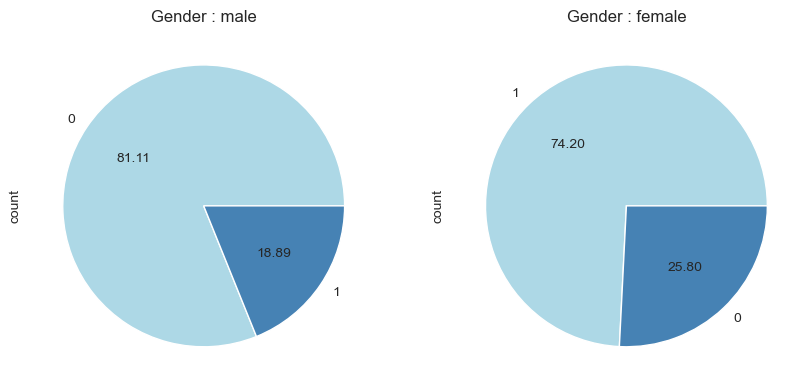

In [14]:
fig = plt.figure(figsize=(10,5))

i = 0
for gender in train_df['Sex'].unique():
    fig.add_subplot(1, 2, i+1)
    plt.title('Gender : {}'.format(gender))
    train_df.Survived[train_df['Sex'] == gender].value_counts().plot(kind='pie', autopct='%.2f', colors=['lightblue', 'steelblue'])
    i += 1

In [15]:
gender_mapping = {'male':0,
                  'female':1}

train_df['Sex'] = train_df['Sex'].apply(lambda x : gender_mapping.get(x)) 
entire_df['Sex'] = entire_df['Sex'].apply(lambda x : gender_mapping.get(x))

In [16]:
embark_mapping = {'S':0,
                  'Q':1,
                  'C':2}

train_df['Embarked'] = train_df['Embarked'].apply(lambda x : embark_mapping.get(x))
entire_df['Embarked'] = entire_df['Embarked'].apply(lambda x : embark_mapping.get(x))

In [17]:
title_mapping = {'Mr':0,
                 'Dr':1,
                 'Master':2,
                 'Miss':3,
                 'Mrs':4}

train_df['Title'] = train_df['Title'].apply(lambda x : title_mapping.get(x)) 
entire_df['Title'] = entire_df['Title'].apply(lambda x : title_mapping.get(x))

In [18]:
fam_mapping = {11:0,
               8:0,
               6:2,
               5:3,
               1:4,
               7:5,
               2:6,
               3:7,
               4:8}

train_df['Fam'] = train_df['Fam'].apply(lambda x : fam_mapping.get(x)) 
entire_df['Fam'] = entire_df['Fam'].apply(lambda x : fam_mapping.get(x))

In [19]:
from sklearn.preprocessing import OrdinalEncoder

features = ['Name', 'Ticket']

for feat in features:
    entire_df[feat] = OrdinalEncoder().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [20]:


features = ['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch', 'Ticket','Embarked', 'Fam', 'Title']

for feat in features:
    entire_df[feat] = MinMaxScaler().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [21]:
entire_df.drop(['Cabin'], axis=1, inplace=True)

<Axes: >

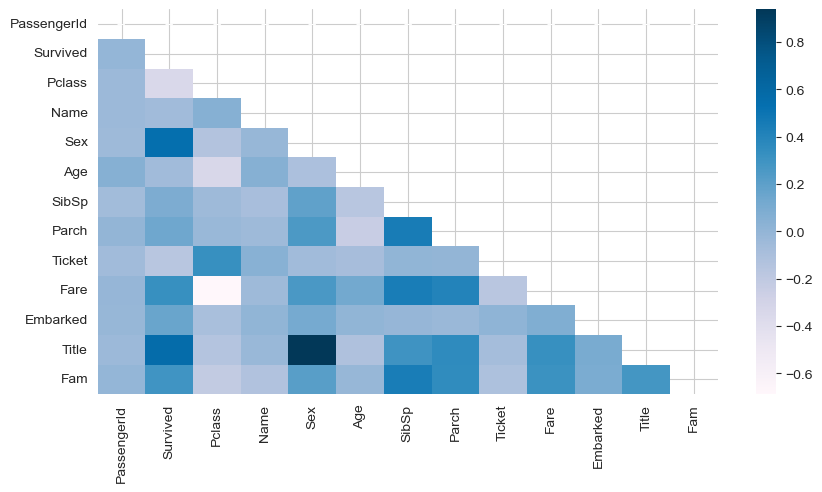

In [22]:
train_df = (entire_df.iloc[0:891]).copy()
corr_matrix = train_df.corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True,  mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), cmap='PuBu')

In [56]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam'],
      dtype='object')

Random Forest:
  Accuracy (Train): 100.00%
  Accuracy (Test): 86.57%
  Log Loss (Train): 0.1011
  Log Loss (Test): 0.3996
--------------------------------------------------
SGD:
  Accuracy (Train): 63.94%
  Accuracy (Test): 58.96%
  Log Loss (Train): 12.9986
  Log Loss (Test): 14.7940
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 77.41%
  Accuracy (Test): 79.10%
  Log Loss (Train): 3.4290
  Log Loss (Test): 3.4816
--------------------------------------------------
KNN:
  Accuracy (Train): 72.39%
  Accuracy (Test): 54.48%
  Log Loss (Train): 0.5337
  Log Loss (Test): 2.2870
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 80.45%
  Accuracy (Test): 80.60%
  Log Loss (Train): 0.7817
  Log Loss (Test): 0.7384
--------------------------------------------------
SVC:
  Accuracy (Train): 62.22%
  Accuracy (Test): 58.21%
  Log Loss (Train): 0.4896
  Log Loss (Test): 0.5222
------------------------------------------

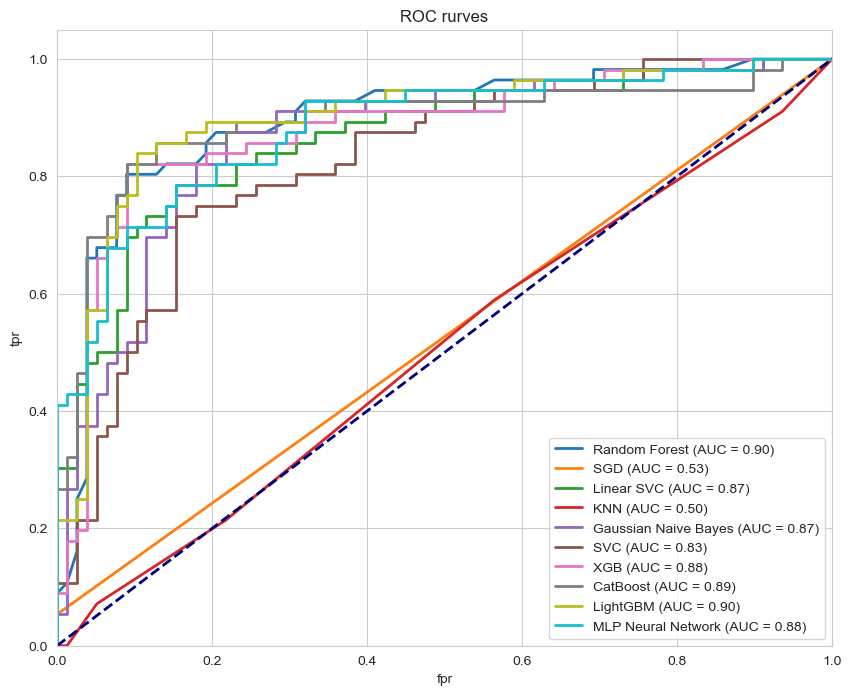

In [107]:
## lets evaluate validation sample

X = train_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]
y = train_df['Survived']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state=42)  
class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = y_train
        self.X_test = X_valid
        self.Y_test = y_valid
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, y_train, X_valid, y_valid)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

In [108]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

def calculate_log_loss(model, X_train, y_train, X_valid, y_valid):
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train)
        probas_test = model.predict_proba(X_valid)
    else:
        probas_train = model.decision_function(X_train)
        probas_test = model.decision_function(X_valid)

    log_loss_train = log_loss(y_train, probas_train)
    log_loss_test = log_loss(y_valid, probas_test)
    return log_loss_train, log_loss_test

# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, y_train)
        
        # Accuracy
        acc_train = accuracy_score(y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(y_valid, model.predict(X_valid)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, y_train, X_valid, y_valid)
        
        # Precision
        precision_train = precision_score(y_train, model.predict(X_train))
        precision_test = precision_score(y_valid, model.predict(X_valid))
        
        # Recall
        recall_train = recall_score(y_train, model.predict(X_train))
        recall_test = recall_score(y_valid, model.predict(X_valid))
        
        # F1-Score
        f1_train = f1_score(y_train, model.predict(X_train))
        f1_test = f1_score(y_valid, model.predict(X_valid))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        else:
            roc_auc_train = roc_auc_score(y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(y_valid, model.decision_function(X_valid))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='Score_test', ascending=False)
models_comparison






,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
7,CatBoost,95.244386,86.567164,0.187151,0.389819,0.980769,0.865385,0.891608,0.803571,0.934066,0.833333,0.989228,0.892399
0,Random Forest,100.000000,85.820896,0.102364,0.623634,1.000000,0.849057,1.000000,0.803571,1.000000,0.825688,1.000000,0.905678
8,LightGBM,100.000000,85.820896,0.041246,0.467032,1.000000,0.849057,1.000000,0.803571,1.000000,0.825688,1.000000,0.897665
6,XGB,100.000000,84.328358,0.025755,0.551257,1.000000,0.857143,1.000000,0.750000,1.000000,0.800000,1.000000,0.881181
4,Gaussian Naive Bayes,80.449141,80.597015,0.781729,0.738378,0.741259,0.767857,0.741259,0.767857,0.741259,0.767857,0.852174,0.866529
2,Linear SVC,79.524439,79.850746,3.604748,3.692380,0.711974,0.737705,0.769231,0.803571,0.739496,0.769231,0.849524,0.867445
9,MLP Neural Network,80.317041,79.850746,0.443989,0.432819,0.766537,0.784314,0.688811,0.714286,0.725599,0.747664,0.859784,0.883700
1,SGD,64.200793,60.447761,12.903342,14.256072,0.758621,1.000000,0.076923,0.053571,0.139683,0.101695,0.535589,0.529762
5,SVC,62.219287,58.208955,0.490917,0.525672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.829005,0.826236
3,KNN,72.391017,54.477612,0.533739,2.286990,0.679070,0.413793,0.510490,0.214286,0.582834,0.282353,0.766399,0.504350


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       134
           1       0.83      0.79      0.81        89

    accuracy                           0.85       223
   macro avg       0.85      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223

Confusion Matrix of Orginal model:


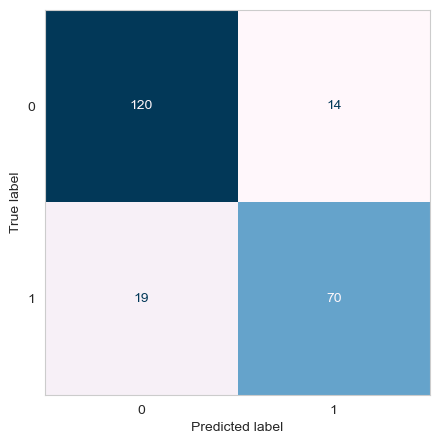

In [63]:


print(classification_report(y_valid, models[8][1].predict(X_valid)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(y_valid, models[8][1].predict(X_valid), colorbar = False, cmap = 'PuBu')
plt.grid(False)

In [110]:
test_df = entire_df.iloc[891:]
test_df = test_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]
test_y = entire_df.iloc[891:, 1]


prediction = models[8][1].predict(test_df)

submission = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
submission['Survived'] = prediction

submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


In [111]:
test_y = entire_df.iloc[891:, 1]

# Accuracy
print(accuracy_score(test_y, prediction))
# Precision
print(precision_score(test_y, prediction))
# Recall
print(recall_score(test_y, prediction))
# F1-Score
print(f1_score(test_y, prediction))



0.8444976076555024
0.8129496402877698
0.743421052631579
0.7766323024054984


In [83]:
submission.to_csv('sub_LightGBM.csv', index= False)

In [112]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       266
           1       0.83      0.76      0.79       152

    accuracy                           0.86       418
   macro avg       0.85      0.84      0.84       418
weighted avg       0.86      0.86      0.86       418

Confusion Matrix of Orginal model:


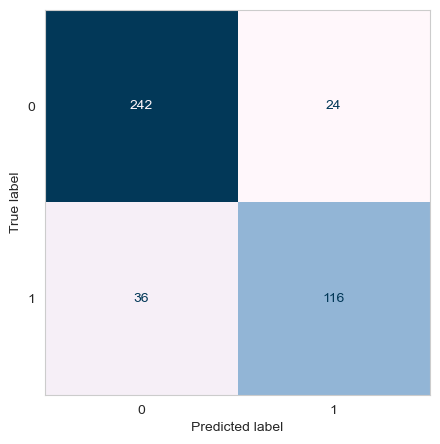

In [ ]:
## test with lg deafult

print(classification_report(test_y ,models[8][1].predict(test_df)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y, models[8][1].predict(test_df), colorbar = False, cmap = 'PuBu')
plt.grid(False)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       266
           1       0.78      0.72      0.75       152

    accuracy                           0.82       418
   macro avg       0.81      0.80      0.81       418
weighted avg       0.82      0.82      0.82       418

Confusion Matrix of Orginal model:


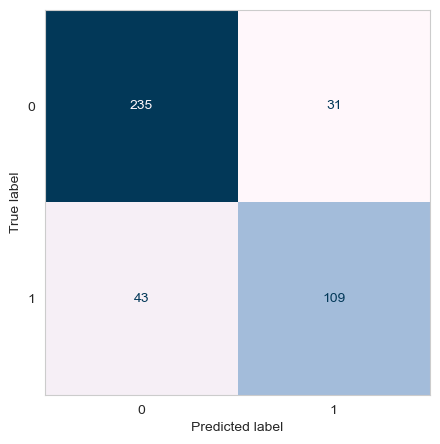

In [ ]:
## test with lg optuned

print(classification_report(test_y , predictions))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y, predictions, colorbar = False, cmap = 'PuBu')
plt.grid(False)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       134
           1       0.93      0.92      0.93        89

    accuracy                           0.94       223
   macro avg       0.94      0.94      0.94       223
weighted avg       0.94      0.94      0.94       223

Confusion Matrix of Orginal model:


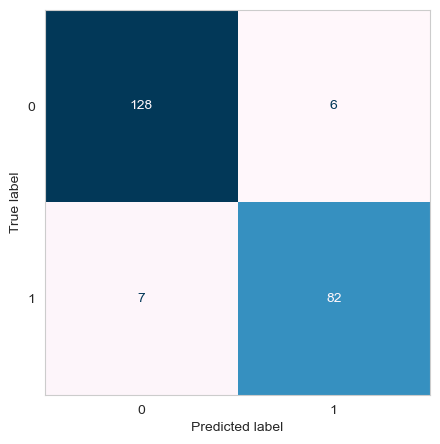

In [100]:
print(classification_report(y_valid, final_model.predict(X_valid)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(y_valid, final_model.predict(X_valid), colorbar = False, cmap = 'PuBu')
plt.grid(False)